# Enable Agent Tutorial Part 3: FDS Context Builder

## 개요

FDS Enable Agent의 분석 결과를 저장하고 지식 베이스로 변환한다.

## 학습 내용

- 분석 결과 자동 로깅
- 사기 패턴 통계 생성
- 자연어 지식 베이스 구축
- RAG를 위한 컨텍스트 준비

---
## 1. 라이브러리 임포트

In [1]:
import json
import yaml
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any

import torch
import torch.nn as nn

from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
print("라이브러리 임포트 완료")

라이브러리 임포트 완료


---
## 2. FDSContextBuilder 클래스 구현

In [2]:
class FDSContextBuilder:
    """FDS 분석 결과를 컨텍스트로 저장하고 관리하는 클래스"""
    
    def __init__(self, context_dir: str = 'context_store'):
        self.context_dir = Path(context_dir)
        self.context_dir.mkdir(exist_ok=True)
        
        self.log_file = self.context_dir / 'analysis_logs.json'
        self.summary_file = self.context_dir / 'fds_summary.json'
        self.knowledge_base_file = self.context_dir / 'fds_knowledge_base.txt'
        
        self.logs = self._load_logs()
        print(f"FDS Context Builder 초기화 완료")
        print(f"저장된 분석 로그: {len(self.logs)}개")
    
    def _load_logs(self) -> List[Dict[str, Any]]:
        if self.log_file.exists():
            with open(self.log_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return []
    
    def add_analysis(self, result: Dict[str, Any]):
        self.logs.append(result)
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.logs, f, indent=2, ensure_ascii=False, default=str)
        print(f"분석 결과 저장 완료 (총 {len(self.logs)}개)")
        self._update_summary()
        self._update_knowledge_base()
    
    def _update_summary(self):
        if not self.logs:
            return
        
        total = len(self.logs)
        fraud_count = sum(1 for l in self.logs if l['is_fraud'])
        
        risk_dist = {'LOW': 0, 'MEDIUM': 0, 'HIGH': 0, 'CRITICAL': 0}
        for log in self.logs:
            risk_dist[log['risk_level']] += 1
        
        avg_score = sum(l['anomaly_score'] for l in self.logs) / total
        avg_amount = sum(l['input_data']['purchase_value'] for l in self.logs) / total
        
        fraud_logs = [l for l in self.logs if l['is_fraud']]
        normal_logs = [l for l in self.logs if not l['is_fraud']]
        
        fraud_avg_time = 0
        normal_avg_time = 0
        if fraud_logs:
            fraud_avg_time = sum(l['derived_features']['time_diff_hours'] for l in fraud_logs) / len(fraud_logs)
        if normal_logs:
            normal_avg_time = sum(l['derived_features']['time_diff_hours'] for l in normal_logs) / len(normal_logs)
        
        summary = {
            "total_analyses": total,
            "fraud_detected": fraud_count,
            "fraud_rate": fraud_count / total if total > 0 else 0,
            "risk_distribution": risk_dist,
            "average_anomaly_score": avg_score,
            "average_purchase_value": avg_amount,
            "fraud_avg_time_diff_hours": fraud_avg_time,
            "normal_avg_time_diff_hours": normal_avg_time,
            "last_updated": datetime.now().isoformat()
        }
        
        with open(self.summary_file, 'w', encoding='utf-8') as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)
    
    def _update_knowledge_base(self):
        if not self.logs:
            return
        
        with open(self.summary_file, 'r', encoding='utf-8') as f:
            summary = json.load(f)
        
        knowledge = f"""# FDS 사기 탐지 지식 베이스

        ## 전체 통계 (마지막 업데이트: {summary['last_updated']})
        
        - 총 분석 건수: {summary['total_analyses']}건
        - 사기 탐지 건수: {summary['fraud_detected']}건
        - 사기 탐지율: {summary['fraud_rate']:.2%}
        - 평균 이상치 점수: {summary['average_anomaly_score']:.2%}
        - 평균 거래 금액: ${summary['average_purchase_value']:.1f}
        
        ## 위험도 분포
        
        - LOW: {summary['risk_distribution']['LOW']}건
        - MEDIUM: {summary['risk_distribution']['MEDIUM']}건
        - HIGH: {summary['risk_distribution']['HIGH']}건
        - CRITICAL: {summary['risk_distribution']['CRITICAL']}건
        
        ## 패턴 분석
        
        - 사기 거래 평균 가입-구매 시간차: {summary['fraud_avg_time_diff_hours']:.1f}시간
        - 정상 거래 평균 가입-구매 시간차: {summary['normal_avg_time_diff_hours']:.1f}시간
        
        ## 최근 분석 기록 (최근 10건)
        
        """
        
        for i, log in enumerate(reversed(self.logs[-10:]), 1):
            status = "사기 의심" if log['is_fraud'] else "정상"
            knowledge += f"""### 분석 #{len(self.logs) - i + 1}
            - 결과: {status} ({log['risk_level']})
            - 점수: {log['anomaly_score']:.2%}
            - 금액: ${log['input_data']['purchase_value']}
            - 시간차: {log['derived_features']['time_diff_hours']:.1f}시간
            - 위험 요인: {', '.join(log['risk_factors']) if log['risk_factors'] else '없음'}
            
            """
        
        with open(self.knowledge_base_file, 'w', encoding='utf-8') as f:
            f.write(knowledge.strip())
    
    def get_knowledge_base_content(self) -> str:
        if self.knowledge_base_file.exists():
            with open(self.knowledge_base_file, 'r', encoding='utf-8') as f:
                return f.read()
        return ""
    
    def get_summary(self) -> Dict[str, Any]:
        if self.summary_file.exists():
            with open(self.summary_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return {}
    
    def clear_logs(self):
        self.logs = []
        for f in [self.log_file, self.summary_file, self.knowledge_base_file]:
            if f.exists():
                f.unlink()
        print("로그 초기화 완료")

print("FDSContextBuilder 클래스 정의 완료")

FDSContextBuilder 클래스 정의 완료


---
## 3. FDSEnableAgent 클래스 (Part 2에서 재사용)

In [3]:
class FraudAutoencoder(nn.Module):
    def __init__(self, input_dim=10, latent_dim=4):
        super(FraudAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16), nn.ReLU(),
            nn.Linear(16, 8), nn.ReLU(),
            nn.Linear(8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8), nn.ReLU(),
            nn.Linear(8, 16), nn.ReLU(),
            nn.Linear(16, input_dim)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def get_reconstruction_error(self, x):
        with torch.no_grad():
            return torch.mean((x - self.forward(x)) ** 2, dim=1)


class FDSEnableAgent:
    def __init__(self, skill_path: str):
        with open(skill_path, 'r', encoding='utf-8') as f:
            self.skill = yaml.safe_load(f)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.iso_forest = joblib.load(self.skill['model_info']['isolation_forest_path'])
        
        checkpoint = torch.load(self.skill['model_info']['autoencoder_path'], map_location=self.device, weights_only=True)
        self.autoencoder = FraudAutoencoder(checkpoint['input_dim'], checkpoint['latent_dim']).to(self.device)
        self.autoencoder.load_state_dict(checkpoint['model_state_dict'])
        self.autoencoder.eval()
        self.ae_threshold = checkpoint['threshold']
        
        self.scaler = joblib.load(self.skill['model_info']['scaler_path'])
        self.label_encoders = joblib.load(self.skill['model_info']['label_encoders_path'])
        with open(self.skill['model_info']['metadata_path'], 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)
        self.risk_thresholds = self.skill['risk_thresholds']
        print(f"FDS Enable Agent 초기화 완료")
    
    def analyze(self, input_data: Dict[str, Any]) -> Dict[str, Any]:
        signup = pd.to_datetime(input_data['signup_time'])
        purchase = pd.to_datetime(input_data['purchase_time'])
        
        derived = {
            'time_diff_hours': (purchase - signup).total_seconds() / 3600,
            'signup_hour': signup.hour,
            'purchase_hour': purchase.hour,
            'is_weekend': 1 if purchase.dayofweek in [5, 6] else 0,
            'is_night': 1 if 0 <= purchase.hour < 6 else 0
        }
        
        features = np.array([[
            input_data['purchase_value'], input_data['age'], derived['time_diff_hours'],
            derived['signup_hour'], derived['purchase_hour'], derived['is_weekend'], derived['is_night'],
            self.label_encoders['source'].transform([input_data['source']])[0],
            self.label_encoders['browser'].transform([input_data['browser']])[0],
            self.label_encoders['sex'].transform([input_data['sex']])[0]
        ]])
        
        features_scaled = self.scaler.transform(features)
        iso_score = -self.iso_forest.score_samples(features_scaled)[0]
        ae_score = self.autoencoder.get_reconstruction_error(
            torch.FloatTensor(features_scaled).to(self.device)
        ).cpu().numpy()[0]
        
        iso_norm = 1 / (1 + np.exp(-2 * (iso_score - 0.5)))
        ae_norm = 1 / (1 + np.exp(-2 * (ae_score / self.ae_threshold - 1)))
        anomaly_score = (iso_norm + ae_norm) / 2
        
        is_fraud = anomaly_score >= self.metadata['ensemble_threshold']
        
        if anomaly_score >= 0.85: risk_level = 'CRITICAL'
        elif anomaly_score >= 0.7: risk_level = 'HIGH'
        elif anomaly_score >= 0.5: risk_level = 'MEDIUM'
        else: risk_level = 'LOW'
        
        factors = []
        if derived['time_diff_hours'] < 1: factors.append("매우 빠른 구매")
        if derived['is_night']: factors.append("심야 거래")
        if input_data['purchase_value'] > 100: factors.append("고액 거래")
        if input_data['source'] == 'Direct': factors.append("직접 유입")
        
        return {
            "is_fraud": bool(is_fraud), "risk_level": risk_level,
            "anomaly_score": float(anomaly_score),
            "isolation_forest_score": float(iso_norm), "autoencoder_score": float(ae_norm),
            "risk_factors": factors, "input_data": input_data,
            "derived_features": derived, "timestamp": datetime.now().isoformat()
        }

print("FDSEnableAgent 클래스 정의 완료")

FDSEnableAgent 클래스 정의 완료


---
## 4. 컴포넌트 초기화 및 테스트

In [4]:
agent = FDSEnableAgent('skills/fds_agent_skill.yaml')
context_builder = FDSContextBuilder()

FDS Enable Agent 초기화 완료
FDS Context Builder 초기화 완료
저장된 분석 로그: 0개


In [5]:
context_builder.clear_logs()

로그 초기화 완료


In [6]:
test_transactions = [
    {'purchase_value': 45, 'age': 35, 'source': 'SEO', 'browser': 'Chrome', 'sex': 'M',
     'signup_time': '2024-01-15T10:30:00', 'purchase_time': '2024-02-20T14:25:00'},
    {'purchase_value': 30, 'age': 28, 'source': 'Ads', 'browser': 'Safari', 'sex': 'F',
     'signup_time': '2024-01-10T09:00:00', 'purchase_time': '2024-01-25T16:30:00'},
    {'purchase_value': 150, 'age': 22, 'source': 'Direct', 'browser': 'Opera', 'sex': 'M',
     'signup_time': '2024-03-10T02:30:00', 'purchase_time': '2024-03-10T02:45:00'},
    {'purchase_value': 200, 'age': 18, 'source': 'Direct', 'browser': 'IE', 'sex': 'F',
     'signup_time': '2024-03-15T03:00:00', 'purchase_time': '2024-03-15T03:01:00'},
    {'purchase_value': 55, 'age': 42, 'source': 'SEO', 'browser': 'FireFox', 'sex': 'M',
     'signup_time': '2024-02-01T11:00:00', 'purchase_time': '2024-02-15T10:00:00'},
    {'purchase_value': 80, 'age': 31, 'source': 'Ads', 'browser': 'Chrome', 'sex': 'F',
     'signup_time': '2024-02-10T14:00:00', 'purchase_time': '2024-02-10T14:30:00'},
    {'purchase_value': 25, 'age': 55, 'source': 'SEO', 'browser': 'Safari', 'sex': 'M',
     'signup_time': '2024-01-20T08:00:00', 'purchase_time': '2024-03-01T12:00:00'},
    {'purchase_value': 180, 'age': 19, 'source': 'Direct', 'browser': 'Chrome', 'sex': 'M',
     'signup_time': '2024-03-20T04:00:00', 'purchase_time': '2024-03-20T04:05:00'},
]

print("=== 분석 및 컨텍스트 저장 ===")
for i, tx in enumerate(test_transactions, 1):
    result = agent.analyze(tx)
    context_builder.add_analysis(result)
    status = "사기" if result['is_fraud'] else "정상"
    print(f"[{i}] {status} - {result['risk_level']} ({result['anomaly_score']:.2%})")

=== 분석 및 컨텍스트 저장 ===
분석 결과 저장 완료 (총 1개)
[1] 정상 - LOW (34.07%)
분석 결과 저장 완료 (총 2개)
[2] 사기 - LOW (35.96%)
분석 결과 저장 완료 (총 3개)
[3] 사기 - HIGH (78.60%)
분석 결과 저장 완료 (총 4개)
[4] 사기 - HIGH (78.26%)
분석 결과 저장 완료 (총 5개)
[5] 사기 - LOW (42.11%)
분석 결과 저장 완료 (총 6개)
[6] 사기 - MEDIUM (51.66%)
분석 결과 저장 완료 (총 7개)
[7] 사기 - MEDIUM (51.42%)
분석 결과 저장 완료 (총 8개)
[8] 사기 - HIGH (78.00%)


---
## 5. 통계 및 지식 베이스 확인

In [7]:
summary = context_builder.get_summary()
print("=== FDS 통계 요약 ===")
print(json.dumps(summary, indent=2, ensure_ascii=False))

=== FDS 통계 요약 ===
{
  "total_analyses": 8,
  "fraud_detected": 7,
  "fraud_rate": 0.875,
  "risk_distribution": {
    "LOW": 3,
    "MEDIUM": 2,
    "HIGH": 3,
    "CRITICAL": 0
  },
  "average_anomaly_score": 0.5625879172965389,
  "average_purchase_value": 95.625,
  "fraud_avg_time_diff_hours": 241.62142857142857,
  "normal_avg_time_diff_hours": 867.9166666666666,
  "last_updated": "2026-01-09T22:29:40.927741"
}


In [8]:
print("=== 지식 베이스 ===")
print(context_builder.get_knowledge_base_content()[:2000])

=== 지식 베이스 ===
# FDS 사기 탐지 지식 베이스

        ## 전체 통계 (마지막 업데이트: 2026-01-09T22:29:40.927741)

        - 총 분석 건수: 8건
        - 사기 탐지 건수: 7건
        - 사기 탐지율: 87.50%
        - 평균 이상치 점수: 56.26%
        - 평균 거래 금액: $95.6

        ## 위험도 분포

        - LOW: 3건
        - MEDIUM: 2건
        - HIGH: 3건
        - CRITICAL: 0건

        ## 패턴 분석

        - 사기 거래 평균 가입-구매 시간차: 241.6시간
        - 정상 거래 평균 가입-구매 시간차: 867.9시간

        ## 최근 분석 기록 (최근 10건)

        ### 분석 #8
            - 결과: 사기 의심 (HIGH)
            - 점수: 78.00%
            - 금액: $180
            - 시간차: 0.1시간
            - 위험 요인: 매우 빠른 구매, 심야 거래, 고액 거래, 직접 유입

            ### 분석 #7
            - 결과: 사기 의심 (MEDIUM)
            - 점수: 51.42%
            - 금액: $25
            - 시간차: 988.0시간
            - 위험 요인: 없음

            ### 분석 #6
            - 결과: 사기 의심 (MEDIUM)
            - 점수: 51.66%
            - 금액: $80
            - 시간차: 0.5시간
            - 위험 요인: 매우 빠른 구매

            ### 분석 #5
            - 결과: 사기 의심 (LOW)
            - 점수: 4

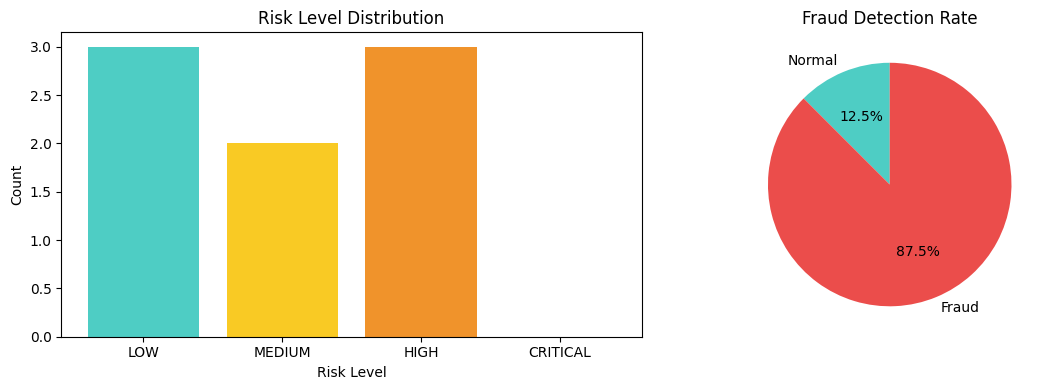

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 위험도 분포
ax = axes[0]
risk_data = summary['risk_distribution']
colors = ['#4ecdc4', '#f9ca24', '#f0932b', '#eb4d4b']
ax.bar(risk_data.keys(), risk_data.values(), color=colors)
ax.set_xlabel('Risk Level')
ax.set_ylabel('Count')
ax.set_title('Risk Level Distribution')

# 사기/정상 비율
ax = axes[1]
fraud_count = summary['fraud_detected']
normal_count = summary['total_analyses'] - fraud_count
ax.pie([normal_count, fraud_count], labels=['Normal', 'Fraud'], 
       autopct='%1.1f%%', colors=['#4ecdc4', '#eb4d4b'], startangle=90)
ax.set_title('Fraud Detection Rate')

plt.tight_layout()
plt.show()